In [3]:
# Importing all the required libraries

import numpy as np 
import pandas as pd 
import os
import re
import distance
import seaborn as sns
from tqdm import tqdm
from fuzzywuzzy import fuzz
from sklearn import metrics
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import Image
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [2]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16275 sha256=6884d6d0de8236ad5bbf5c99e2ed2d6b9c5a8ffcf8895323b79e57a611e2a790
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


# Data Loading

In [4]:
df_train =  pd.read_csv('/kaggle/input/quora-question-pairs/train.csv.zip')
df_train.shape

(404290, 6)

In [7]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Data Understanding

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [9]:
df_train.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [10]:
# Removing missing values from data
df = df_train.loc[~df_train.isnull().any(axis=1),:].copy()
print("Any Rows with Missing Data: ",(df.isna().sum()>0).any())
df['question1'] = df.loc[:,'question1'].apply(lambda x: str(x).strip())
df['question2'] = df.loc[:,'question2'].apply(lambda x: str(x).strip())

Any Rows with Missing Data:  False


In [11]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [12]:
# Check number of unique questions and duplicates in whole corpus
questions_list = pd.concat([df['question1'] , df['question2']] )
unique_quesList = questions_list.value_counts()[questions_list.value_counts()==1].index
duplicate_quesList = questions_list.value_counts()[questions_list.value_counts()>1].index
print("Number of Questions which are unique: ",len(unique_quesList))
print("Number of Questions which are repeated: ",len(duplicate_quesList))
print("Total number of unique questions in dataset: ",len(questions_list.value_counts()))

Number of Questions which are unique:  425464
Number of Questions which are repeated:  111873
Total number of unique questions in dataset:  537337


In [13]:
# Distribution of repeated questions
rep_ques = questions_list.value_counts()[questions_list.value_counts()>1]
rep_ques

What are the best ways to lose weight?                                                    161
How can you look at someone's private Instagram account without following them?           120
How can I lose weight quickly?                                                            111
What's the easiest way to make money online?                                               88
Can you see who views your Instagram?                                                      79
                                                                                         ... 
How do I get girls to see me sexually?                                                      2
Why doesn't IndiGo airlines have a loyalty/frequent flyer program like other airlines?      2
How do I calculate resistance?                                                              2
Can we use non Tata sky dish antenna for Tata Sky set top box?                              2
Is cat worth a 1 year drop?                                 

In [14]:
document_corpus = list(set(list(df['question1']) + list(df['question2'])))
math_q = [q  for q in document_corpus if '[math]' in q]

print("Percentage of Questions with '?' (not necessarily ending with): {0:.3f} %".format(100*len([q  for q in document_corpus if '?' in q])/len(document_corpus)))
print("Percentage of Questions not having '?': {0:.3f} %".format(100*len([q  for q in document_corpus if '?' not in q])/len(document_corpus)))
print("Number of Math based questions:  {0:3f} %".format(100*len(math_q)/len(document_corpus)))
print("Questions with multiple parts: {0:.3f} %".format(100*len([ q for q in document_corpus if len(q.split('?'))>2 ])/len(document_corpus) ))
print("\nExamples of Questions with subparts : ",[ q for q in document_corpus if len(q.split('?'))>2 ][0:2]) 
print("\nPersonal or Opinion-based questions: {0:.3f} %".format(100*len([q for q in document_corpus if ('you' in q) or (' i ' in q) ])/len(document_corpus)))
print("\nSome Personal Or Opinion-based questions: ", [q for q in document_corpus if 'you' in q][:2])

Percentage of Questions with '?' (not necessarily ending with): 99.864 %
Percentage of Questions not having '?': 0.136 %
Number of Math based questions:  0.138647 %
Questions with multiple parts: 5.542 %

Examples of Questions with subparts :  ['Have you ever cried while watching a cricket match? If yes, what brought tears to your eyes?', 'Why do aquatic animals need water to stay alive? What is the science behind it?']

Personal or Opinion-based questions: 12.038 %

Some Personal Or Opinion-based questions:  ['Have you ever cried while watching a cricket match? If yes, what brought tears to your eyes?', 'What features do you wish Facebook had?']


# Data Preprocessing

In [15]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [16]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

/tmp/ipykernel_32/2906366726.py:161: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)


100%|██████████| 8/8 [01:32<00:00, 11.51s/it]


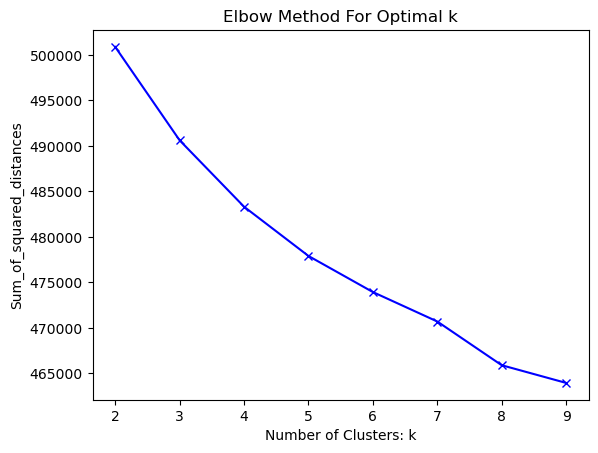

Finding Optimal Cluster Number Done!


<Figure size 640x480 with 0 Axes>

In [17]:
# Clustering of questions
document_corpus = list( set(list(df['question1']) + list(df['question2'])) )
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
x = vectorizer.fit_transform(document_corpus)

Sum_of_squared_distances = []
for k in tqdm(range(2,10)):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(x)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(range(2,10), Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters: k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
print("Finding Optimal Cluster Number Done!")
plt.savefig("cluster_analysis.png")

## TF-IDF Vectorizer

In [18]:
document_corpus = list(set(list(df['question1']) + list(df['question2'])))
questions_cluster = pd.DataFrame({'questions':document_corpus, 'cluster_label':None})
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
x = vectorizer.fit_transform(questions_cluster['questions'].values)
sc_x = StandardScaler()
std_x = sc_x.fit_transform(x.toarray())

100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


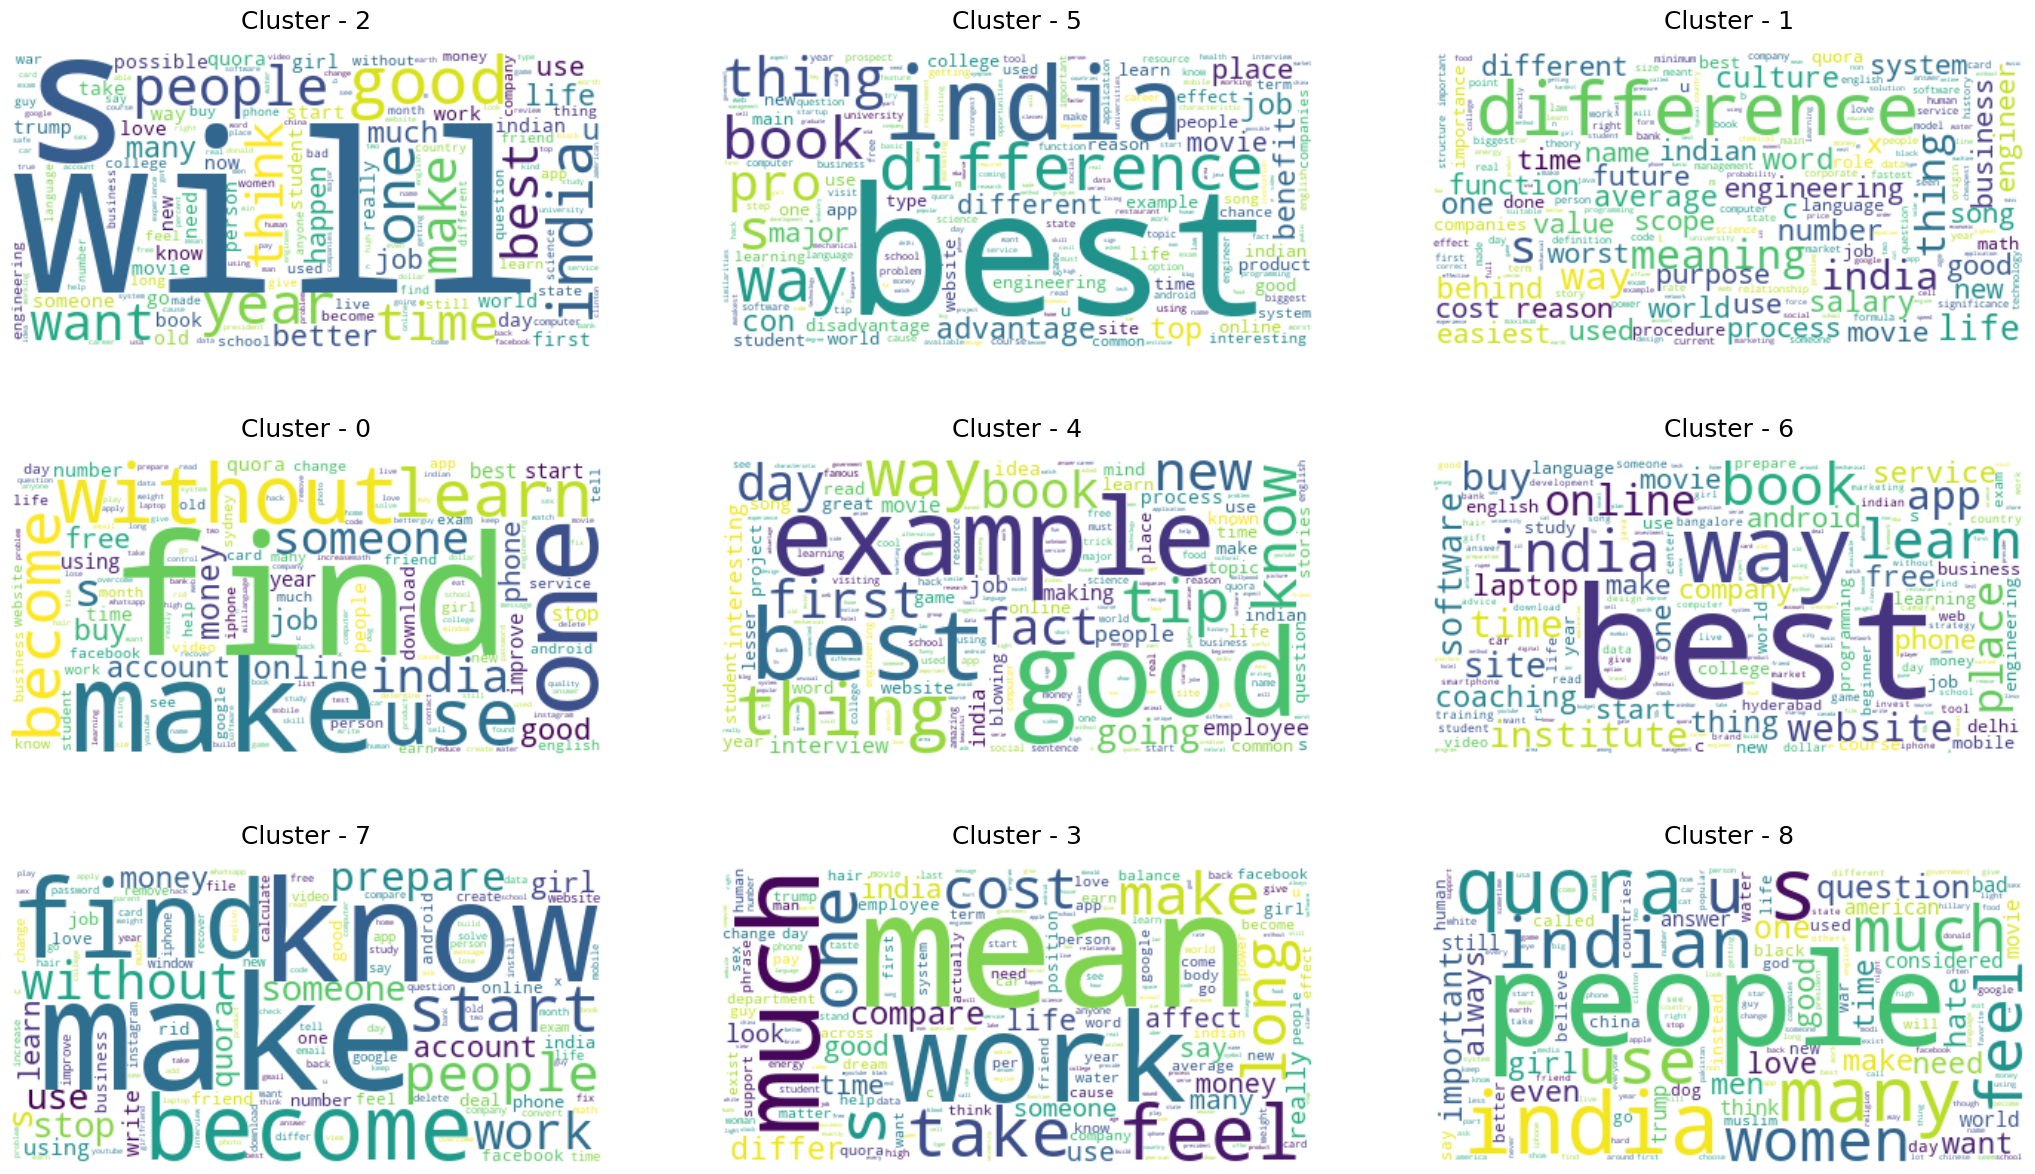

In [19]:
# Major word in each word cloud
document_corpus = list(set(list(df['question1']) + list(df['question2'])))
questions_cluster = pd.DataFrame({'questions':document_corpus, 'cluster_label':None})
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,4))
x = vectorizer.fit_transform(questions_cluster['questions'].values)
km = KMeans(n_clusters=9, max_iter=500, n_init=30)
km = km.fit(x)
questions_cluster['cluster_label'] = km.labels_


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(26,15))
i=1
for cluster in tqdm(questions_cluster['cluster_label'].unique()):
    questions = " ".join(questions_cluster[questions_cluster['cluster_label']==cluster]['questions'].values)
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(questions)
    plt.subplot(3,3,i)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title("Cluster - "+str(cluster), fontsize=18,pad=17)
    plt.axis("off")
    i+=1
    
#fig.delaxes(axes.flatten()[5])
plt.show()

In [20]:
df = pd.merge( left=pd.merge(left=df, right=questions_cluster, left_on="question1", right_on="questions"), right=questions_cluster , left_on="question2", right_on="questions")
df.drop(["questions_x","questions_y"], axis=1, inplace=True)
df.rename(columns={'cluster_label_x':'q1_cluster','cluster_label_y':'q2_cluster'}, inplace=True)
print("Train Questions cluster labelling Done!")
df.head()

Train Questions cluster labelling Done!


,id,qid1,qid2,question1,question2,is_duplicate,q1_cluster,q2_cluster
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,2
2,184732,3,282170,what is the story of kohinoor koh i noor dia...,is it possible to melt down diamonds,0,1,2
3,263614,3,380197,what is the story of kohinoor koh i noor dia...,what are some interesting facts about kohinoor...,0,1,4
4,359232,3,488853,what is the story of kohinoor koh i noor dia...,could india keep the koh i noor safe,0,1,2


In [21]:
df = pd.merge( pd.merge(df,pd.DataFrame({'qid1':df['qid1'].value_counts().index.values,
                                         'freq_qid1':df['qid1'].value_counts().values}), on='qid1',how="left"),pd.DataFrame({'qid2':df['qid2'].value_counts().index.values,
                                                                                                                             'freq_qid2':df['qid2'].value_counts().values}) ,on='qid2', how='left')

In [22]:
# Feature extraction
df['is_duplicate'] = df['is_duplicate'].apply(lambda x: "Yes" if x==1 else "No")
df.loc[:,['q1_length']] = df['question1'].apply(lambda x: len(x)).values
df.loc[:,['q2_length']] = df['question2'].apply(lambda x: len(x)).values
df['same_cluster'] = df[['q1_cluster','q2_cluster']].apply(lambda x: 1 if x[0]==x[1] else 0, axis=1)
df['q1_wordsCount'] = df['question1'].apply(lambda x: len(x.split(" ")))
df['q2_wordsCount'] = df['question2'].apply(lambda x: len(x.split(" ")))
df['common_wordsCount'] = df[['question1','question2']].apply(lambda x: len(set(x[0].split(" ")).intersection(set(x[1].split(" ")))) , axis=1 )
df['q1_freq+q2_freq'] = df['freq_qid1']+df['freq_qid2']
df['q1_freq-q2_freq'] = abs(df['freq_qid1']-df['freq_qid2'])
df['total_word_share'] = 2*df['common_wordsCount']/(df['q1_wordsCount']+df['q2_wordsCount'])
print("Train Data Basic Feature Engineering Done!")
df.head()

/tmp/ipykernel_32/2553182204.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,['q1_length']] = df['question1'].apply(lambda x: len(x)).values
/tmp/ipykernel_32/2553182204.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,['q2_length']] = df['question2'].apply(lambda x: len(x)).values


Train Data Basic Feature Engineering Done!


,id,qid1,qid2,question1,question2,is_duplicate,q1_cluster,q2_cluster,freq_qid1,freq_qid2,q1_length,q2_length,same_cluster,q1_wordsCount,q2_wordsCount,common_wordsCount,q1_freq+q2_freq,q1_freq-q2_freq,total_word_share
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,No,1,1,1,1,65,56,1,14,12,11,2,0,0.846154
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,No,1,2,4,1,50,87,0,12,17,8,5,3,0.551724
2,184732,3,282170,what is the story of kohinoor koh i noor dia...,is it possible to melt down diamonds,No,1,2,4,1,50,36,0,12,7,1,5,3,0.105263
3,263614,3,380197,what is the story of kohinoor koh i noor dia...,what are some interesting facts about kohinoor...,No,1,4,4,1,50,54,0,12,8,3,5,3,0.300000
4,359232,3,488853,what is the story of kohinoor koh i noor dia...,could india keep the koh i noor safe,No,1,2,4,1,50,36,0,12,8,4,5,3,0.400000


In [23]:
# Finding Cosine Similarity from TF-IDF Text Vectors
document_corpus = list(df['question1'])+list(df['question2'])
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(document_corpus)
q1_vectors = x[: (x.shape[0]//2) , :]
q2_vectors = x[(x.shape[0]//2) : , :]

ques_pair_vectors=[]
for i in tqdm(range(q1_vectors.shape[0])):
    ques_pair_vectors.append(q1_vectors[i].dot(q2_vectors[i].T).toarray()[0][0]   )

df['cosine_similarity'] = ques_pair_vectors
print("Train Data cosine_similarity Done !")
df.head()

100%|██████████| 404287/404287 [03:26<00:00, 1960.89it/s]


Train Data cosine_similarity Done !


,id,qid1,qid2,question1,question2,is_duplicate,q1_cluster,q2_cluster,freq_qid1,freq_qid2,q1_length,q2_length,same_cluster,q1_wordsCount,q2_wordsCount,common_wordsCount,q1_freq+q2_freq,q1_freq-q2_freq,total_word_share,cosine_similarity
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,No,1,1,1,1,65,56,1,14,12,11,2,0,0.846154,0.978506
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,No,1,2,4,1,50,87,0,12,17,8,5,3,0.551724,0.749980
2,184732,3,282170,what is the story of kohinoor koh i noor dia...,is it possible to melt down diamonds,No,1,2,4,1,50,36,0,12,7,1,5,3,0.105263,0.010185
3,263614,3,380197,what is the story of kohinoor koh i noor dia...,what are some interesting facts about kohinoor...,No,1,4,4,1,50,54,0,12,8,3,5,3,0.300000,0.497081
4,359232,3,488853,what is the story of kohinoor koh i noor dia...,could india keep the koh i noor safe,No,1,2,4,1,50,36,0,12,8,4,5,3,0.400000,0.577134


In [24]:
df.isna().sum()

id                   0
qid1                 0
qid2                 0
question1            0
question2            0
is_duplicate         0
q1_cluster           0
q2_cluster           0
freq_qid1            0
freq_qid2            0
q1_length            0
q2_length            0
same_cluster         0
q1_wordsCount        0
q2_wordsCount        0
common_wordsCount    0
q1_freq+q2_freq      0
q1_freq-q2_freq      0
total_word_share     0
cosine_similarity    0
dtype: int64

# Model Building

In [27]:
X= df.copy()
X.drop(['id','qid1','qid2','question1','question2','is_duplicate','q1_cluster', 'q2_cluster'], axis=1, inplace=True)
sc_x = StandardScaler()
X.insert(loc=0, column='x0', value=[1]*len(X))
X.iloc[:,1:-1] = sc_x.fit_transform(X.iloc[:,1:-1])
y=df['is_duplicate'].apply(lambda x: 0 if x=="No" else 1)
X.shape, y.shape

((404287, 13), (404287,))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
model = LogisticRegression(penalty='l2', solver='liblinear')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
accuracy_score(y_test,y_pred)

0.7708861009973088

In [30]:
cm=confusion_matrix(y_test,y_pred)
cm

array([[55489,  8122],
       [15035, 22426]])

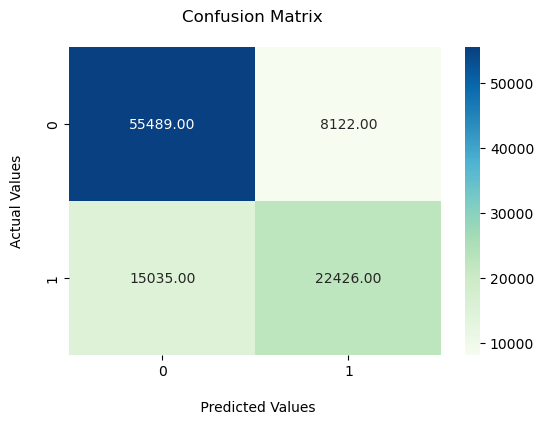

In [31]:
# Plotting confusion matrix
plt.figure(figsize=(6,4))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
plt.show()